# Modeling True Positive and True Negative rates

We want to use the Bivariate Beta distribution built in the previous
sections. Before integrating it to the whole model, we consider a model for
sensibility and sensitivity as follows: 

Let $Y_p$ denote the number of positives tests in $n_{pos}$ individuals who
were exposed to a disease, and $Y_n$ denote the number of negative tests in
$n_{neg}$ not exposed. The person is tested with a gold standard, which is the
best benchmark and the most accurate possible.

Remind that the sensitivity $\gamma_s$ is the probability of a test being positive given
the exposition, while the specificity $\gamma_e$ is the probability of a
negative test given the non-exposition. 
Therefore, 

\begin{align*}
    Y_p &\sim Binomial(n_{pos}, \gamma_s) \\
    Y_n &\sim Binomial(n_{neg}, \gamma_e) \\
    \gamma_s &= U_1 + U_2 \\
    \gamma_e &= U_1 + U_3, 
\end{align*}

such that $(U_1, U_2, U_3, U_4) \sim Dirichlet(\alpha_1, \alpha_2, \alpha_3, \alpha_4)$. 
Besides that, there are two different models to handle with
$\alpha = (\alpha_1, \dots, \alpha_4)$. 

I. $\alpha_i \sim \operatorname{Gamma}(a^i, b^i)$, with $a^i$ and $b^i$ fixed. 

II. $\alpha_i \sim \operatorname{Dirac}(\hat{\alpha}_i)$ such that $\hat{\alpha}_i$
is calculated as explained before. 

In [1]:
import numpy as np
import pystan as ps

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
sns.set()

%matplotlib inline

import pickle

import sys
sys.path.append('../scripts/')

from utilits import ParameterAlpha, BivariateBeta

## Model 

First we code the model in Stan and use PyStan as a Python interface. 

In [27]:
compiled = True
#compiled = False

if compiled: 
    sm = pickle.load(open('../models/sensitivity_specificity/spec_sens_model_constant_alpha.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/sensitivity_specificity/spec_sens_model_constant_alpha.stan')
    with open('../models/sensitivity_specificity/spec_sens_model_constant_alpha.pkl', 'wb') as f:
        pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_283154543b71871021ef1d48f344f3a6 NOW.


### Data and parameter blocks

Observe that we have a boolean variable to distinguish both models. 

In [28]:
structure = sm.model_code.split('}')
print(structure[0] + '}' + structure[1]+'}' + structure[2]+'}') 

data {
    int<lower = 0> n_pos;
    int<lower = 0> n_neg; 
    int Y_p;
    int Y_n;
    vector<lower = 0>[4] alpha_data;
}
parameters {
    simplex[4] U; 
}
transformed parameters{ 
    real<lower = 0, upper = 1> sens;
    real<lower = 0, upper = 1> spec; 
    sens = U[1] + U[2];
    spec = U[1] + U[3];
}


### Model block 

In [29]:
print(structure[3] + '}') 


model {
    U ~ dirichlet(alpha_data);
    Y_p ~ binomial(n_pos, sens);
    Y_n ~ binomial(n_neg, spec);
}


## Toy example 

First we need to test the model with fake data. This is done to verify how the it behaves in a controlled space. 

In [30]:
n_pos = 50
n_neg = 45

sens = 0.8 
spec = 0.9

Y_p = np.random.binomial(n = n_pos, p = sens)
Y_n = np.random.binomial(n = n_neg, p = spec)

m1, m2, v1, v2, rho = sens, spec, (0.05)**2, (0.05)**2, -0.3

solution = ParameterAlpha().minimizer(m1,m2,v1,v2,rho, c = [1,1,1,1])

Notice that the estimated values are below: 

In [31]:
BivariateBeta().moments_calculus(solution.x)

(0.7605622599670436,
 0.8451216472124901,
 0.0028470020826766042,
 0.00204630495469627,
 -0.2401953043476225)

In [60]:
data = {
    "n_pos": n_pos, 
    "n_neg": n_neg, 
    "Y_p": Y_p, 
    "Y_n": Y_n, 
    "alpha_data": solution.x
}

In [61]:
fit = sm.sampling(data=data, iter=5000, chains=4, 
                  control = {'adapt_delta': 0.99})

In [62]:
fit

Inference for Stan model: anon_model_283154543b71871021ef1d48f344f3a6.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

             mean se_mean     sd    2.5%     25%     50%    75%  97.5%  n_eff   Rhat
U[1]         0.68  9.9e-4   0.05    0.58    0.64    0.68   0.71   0.77   2341    1.0
U[2]         0.13  7.5e-4   0.03    0.07    0.11    0.13   0.15    0.2   1923    1.0
U[3]         0.19  7.7e-4   0.04    0.12    0.16    0.19   0.21   0.27   2380    1.0
U[4]       3.0e-4  2.3e-5 1.8e-3 5.6e-17 7.9e-14 3.0e-10 1.3e-6 2.9e-3   6359    1.0
sens         0.81  7.7e-4   0.04    0.73    0.78    0.81   0.83   0.88   2375    1.0
spec         0.87  7.5e-4   0.03     0.8    0.85    0.87   0.89   0.93   1935    1.0
U_prior[1]   0.61  6.1e-4   0.06    0.48    0.56    0.61   0.65   0.72   9944    1.0
U_prior[2]   0.16  4.5e-4   0.05    0.08    0.12    0.15   0.18   0.25  10033    1.0
U_prior[3]   0.24  5.2e-4   0.05    0.14     

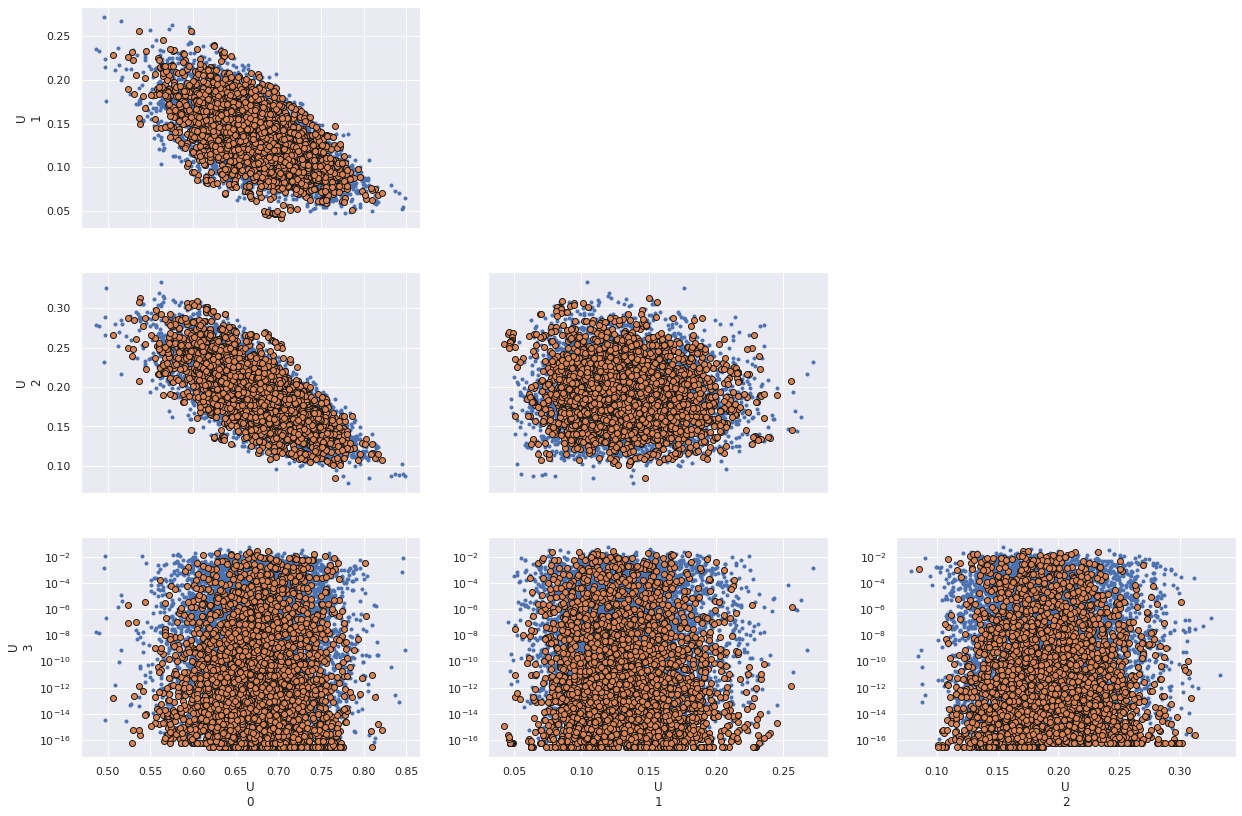

In [63]:
inference_data = az.convert_to_inference_data(fit)
ax = az.plot_pair(inference_data, var_names=('U'), divergences=True, group = 'posterior')
for i in range(3): ax[2][i].set_yscale('log')
plt.show()

Here we use a modification explained in [here]()

In [135]:
#compiled = True
compiled = False

if compiled: 
    sm = pickle.load(open('../models/sensitivity_specificity/spec_sens_model_constant_alpha_smooth.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/sensitivity_specificity/spec_sens_model_constant_alpha_smooth.stan')
    with open('../models/sensitivity_specificity/spec_sens_model_constant_alpha_smooth.pkl', 'wb') as f:
        pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_687ec2a1287966d2c97ca899ce20f61c NOW.


In [136]:
fit = sm.sampling(data=data, iter=5000, chains=4)

In [137]:
fit

Inference for Stan model: anon_model_687ec2a1287966d2c97ca899ce20f61c.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

              mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
Z[1]          0.32  6.7e-4   0.05    0.24    0.29   0.32   0.36   0.42   5106    1.0
Z[2]          0.59  1.1e-3   0.08    0.43    0.53   0.59   0.64   0.74   5240    1.0
Z[3]        1.4e-3  9.0e-5 7.4e-3 2.2e-16 5.1e-13 1.7e-9 7.4e-6   0.02   6877    1.0
sens          0.81  5.1e-4   0.04    0.73    0.78   0.81   0.84   0.88   5358    1.0
spec          0.87  4.6e-4   0.03    0.79    0.84   0.87   0.89   0.92   5093    1.0
Z_prior[1]    0.39  6.2e-4   0.06    0.28    0.35   0.39   0.44   0.52   9934    1.0
Z_prior[2]    0.61  9.6e-4    0.1    0.42    0.54   0.61   0.68   0.79  10010    1.0
Z_prior[3] 3.2e-10     nan 3.2e-8     0.0     0.0    0.0    0.0    0.0    nan    1.0
sens_prior    0.76  5.4e-4   0.05    0.65    

> Why is this happening? 

Let's see what is $Z_3$! Below are the only non-zero samples!

In [151]:
samples = fit.extract()['Z_prior'][:,2]
samples = samples[samples != 0]
samples

array([2.80272158e-237, 3.66874570e-258, 1.53335322e-047, 2.73823749e-164,
       2.42905459e-215, 2.14174058e-086, 3.22377371e-006])

And the 0.9999-quartile is `1e-55`, that is, the probability mass is all in zero! This happens because $b \gg a$. 

In [183]:
z_3.ppf(0.9999)

1.4222706865628329e-55

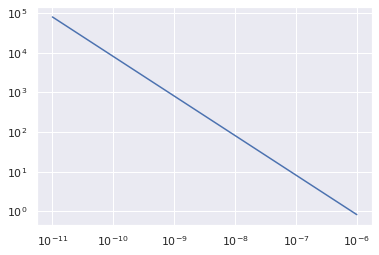

In [171]:
from scipy.stats import beta as beta_dist

z_3 = beta_dist(a = solution.x[-1], b = solution.x[-2])

t = np.linspace(0,1e-6,100000)

plt.plot(t, z_3.pdf(t))
plt.xscale('log')
plt.yscale('log')